In [48]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
%%capture
#generate data
env = TwoPlayerDubinsCarEnv()

state = env.reset()
X = []
y = []
for i in range(20000):
    for player in env.players:
        state = env.reset()
        action = env.action_space[player].sample() 
        X.append(np.hstack([state['attacker'], state['defender']]))
        r = env.sample(state, action, player,0.5)
        y.append(r)

X = np.array(X)
y = np.array(y)

print(X[:5])
print(y[:5])


In [98]:
X

array([[-4.5710519e-02, -8.2336940e-02,  1.1529697e+00,  2.6362002e+00,
        -2.4705005e+00, -2.3915008e-01],
       [ 1.7776146e+00, -2.1231925e+00,  1.8833361e+00, -1.9306371e-01,
        -1.4558840e+00,  1.2001156e+00],
       [ 1.0307873e+00,  2.1125236e+00, -1.8547463e-01,  2.6026426e-02,
         1.9488916e+00,  3.0758810e+00],
       ...,
       [ 2.7448483e+00,  2.7387583e+00, -2.6576014e+00, -2.0562732e+00,
        -9.2416035e-04, -1.2210879e+00],
       [-1.3057722e+00, -2.1559503e+00, -9.0562946e-01,  2.5374034e-01,
         1.6989813e+00, -1.0948132e+00],
       [ 2.7665311e-01, -1.5146909e+00,  2.9981783e-01,  5.4083776e-01,
        -1.0924902e+00,  5.1693213e-01]], dtype=float32)

In [99]:
#X_train = (X - X.mean())/(X.std())


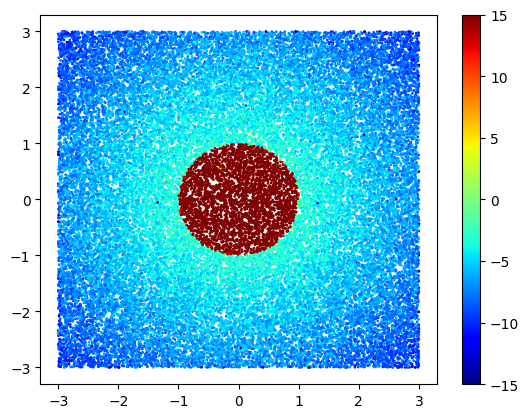

In [100]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()

In [73]:
print(len(X))
print(len(y))

100000
100000


In [95]:
%%capture
#generate data
env = TwoPlayerDubinsCarEnv()

state = env.reset()
X = []
y = []
for i in range(50000):
    for player in env.players:
        state = env.reset()
        X.append(np.hstack([state['attacker'], state['defender']]))


X = np.array(X)



In [ ]:
len(X)

In [112]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

#     return l5

#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(18)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse





optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)
batch_size = 50000

# for epoch in range(3000):
#     loss, grads = jax.value_and_grad(loss_fn)(params,X=X,y=y)
#     print("progress:", "epoch:", epoch, "loss",loss)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)

for epoch in range(10):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.99)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch,'batch:',batch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
# After training
print("estimation of the parameters:")
print(params)



progress: epoch: 0 batch: 0 loss 26.4461
progress: epoch: 1 batch: 0 loss 26.445698
progress: epoch: 2 batch: 0 loss 26.445568
progress: epoch: 3 batch: 0 loss 26.445696
progress: epoch: 4 batch: 0 loss 26.446106
progress: epoch: 5 batch: 0 loss 26.44681
progress: epoch: 6 batch: 0 loss 26.447803
progress: epoch: 7 batch: 0 loss 26.449076
progress: epoch: 8 batch: 0 loss 26.450619
progress: epoch: 9 batch: 0 loss 26.452438
estimation of the parameters:
{'linear': {'b': Array([ 0.01002038,  0.01001571,  0.01001051, -0.00995907, -0.00996727,
       -0.00995415, -0.00997176,  0.01000592,  0.01002184, -0.00997183,
       -0.00981083, -0.00998609, -0.00997552, -0.00997854, -0.00998229,
        0.01002194, -0.00996214, -0.00998211], dtype=float32), 'w': Array([[ 0.18995664, -0.02581276,  0.69350034, -0.13568583, -0.64615154,
         0.6561886 , -0.55728495,  0.02158692, -0.07434007, -0.32856917,
         0.16333605, -0.00366748,  0.16488867,  0.660149  ,  0.23311749,
         0.14335568,  0

In [ ]:
test_state = env.reset()
input = np.hstack([test_state['attacker'], test_state['defender']])
estimate  = forward(X=input, params=params)
print("estimate", estimate)

In [111]:
env = TwoPlayerDubinsCarEnv()
state = env.reset()
done = False
max_iter = 200
counter = 0
print(env.car_position)
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for d_action in range(env.action_space['defender'].n):
        state_ , reward, done, info = env.state_action_step(state, d_action, 'defender')
        defender_actions = []
        for a_action in range(env.action_space['attacker'].n):
            next_state, reward, _, _ = env.state_action_step(state_, a_action, 'attacker')
            input = np.hstack([next_state['attacker'], next_state['defender']])
            estimate  = forward(X=input, params=params)
            print('estimate', estimate, 'actual', reward)
            possible_actions.append([d_action, a_action, estimate[0]])
        pa = np.array(possible_actions)
    cand_attack_actions = np.argmax(pa.T,axis=0)
    best_defender_action =  np.argmin(np.max(pa.T,axis=0))
    best_attacker_action = cand_attack_actions[best_defender_action]
    print(counter)




    state, reward, done, _ = env.step(best_defender_action, 'defender')
    state, reward, done, _ = env.step(best_attacker_action, 'attacker')

    env.render()
    
env.make_gif()

reset {'attacker': array([ 2.6013424 , -0.52065104,  1.7902702 ], dtype=float32), 'defender': array([-0.00510301, -2.6809986 , -1.374843  ], dtype=float32)}
{'attacker': array([ 2.6013424 , -0.52065104,  1.7902702 ], dtype=float32), 'defender': array([-0.00510301, -2.6809986 , -1.374843  ], dtype=float32)}
estimate [-0.07735637] actual -4.297199668880489
estimate [-0.07926497] actual -4.2962167610245725
estimate [-0.10417025] actual -4.2945625048239515
estimate [-0.08371697] actual -4.296334136409596
estimate [-0.08562563] actual -4.295493945749193
estimate [-0.11053076] actual -4.29398195764199
estimate [-0.11797623] actual -4.295715197877747
estimate [-0.11988494] actual -4.295018565045572
estimate [-0.14479002] actual -4.293649481456313
1
estimate [-0.04819262] actual -4.2989423643565345
estimate [-0.05012173] actual -4.299162307171498
estimate [-0.07505234] actual -4.298708815035289
estimate [-0.05452992] actual -4.302041081121515
estimate [-0.05645891] actual -4.302405543570924
es

In [ ]:
possible_actions

In [ ]:
import pandas as pd
df = pd.DataFrame(possible_actions, columns=['defender', 'attacker','value'])
df


In [ ]:
pa = np.array(possible_actions)
pa = pa[:,2].reshape(3,3)
pa

In [ ]:
best_attacker_moves = np.argmax(pa.T,axis=0)

best_defender_move =  np.argmin(np.max(pa.T,axis=0))

best_attacker_move = best_attacker_moves[best_defender_move]
print(best_defender_move,best_attacker_move)


In [ ]:
pa[best_defender_move][best_attacker_move]

In [ ]:
possible_actions